In [1]:
import sys
sys.path.insert(0,'../')

from modERec import EnergyRec, SymFit
import numpy as np

* EnergyRec default values summary:
--> bool_plot =  False
--> bool_EarlyLate =  True
--> nu_low =  50
--> nu_high =  200
--> SNR_thres =  10
--> thres_low =  1e-07
--> thres_high =  1
--> f_thres =  0.01
--> printLevel =  0




# Training stage of $a_{ratio}$

The following blocks are used to train the method and determine the parameters of $a_{ratio}$.

$$a(r,d_{max},\rho_{max};{\boldsymbol p}) = p_0.\frac{r}{d_{max}}.\exp \left(\frac{r}{p_1}\right).
\left[ \exp\left(\frac{\rho_{max}-<\rho_{max}>}{p_2}\right)-p_3\right]$$

The first step is to evaluate several quantities of interest: geomagnetic fluence, charge excess fluence, geomagnetic angle, axis distance of the antennas, distance to the $X_{max}$ and density at the $X_{max}$.

In [2]:
def quantities(sim_dir):
    rec = EnergyRec(sim_dir)

    weight = np.array([ant.wEarlyLate for ant in rec.antenna])
    r_proj = np.array([ant.r_proj for ant in rec.antenna])
    fluence_geo = np.array([ant.fluence_geo for ant in rec.antenna])/(weight**2)
    fluence_ce = np.array([ant.fluence_ce for ant in rec.antenna])/(weight**2)

    n_ant = len(rec.GRANDshower.fields)
    alpha = np.full(n_ant,np.arccos(np.dot(rec.shower.ev,rec.shower.eB)))
    distance = np.linalg.norm((r_proj - rec.shower.r_Core_proj)[:,0:2],axis=1)*weight
    d_Xmax = np.full(n_ant,rec.shower.d_Xmax)
    rho_Xmax = np.full(n_ant,SymFit.rho(d_Xmax[0],-rec.shower.ev))
    
    return fluence_geo, fluence_ce, alpha, distance, d_Xmax, rho_Xmax

### Loop over the simulations

Loop over the simulations and store the corresponding quantities.

In [3]:
fluence_geo = np.array([])
fluence_ce = np.array([])
alpha = np.array([])
distance = np.array([])
d_Xmax = np.array([])
rho_Xmax = np.array([])

for i in range(100001,100008):
    simulation = "../files/sim" + str(i) + ".hdf5"

    f_geo, f_ce, a, d, d_max, rho_max = quantities(simulation)
    fluence_geo = np.append(fluence_geo,f_geo)
    fluence_ce = np.append(fluence_ce,f_ce)
    alpha = np.append(alpha,a)
    distance = np.append(distance,d)
    d_Xmax = np.append(d_Xmax,d_max)
    rho_Xmax = np.append(rho_Xmax,rho_max)

### Perform the fit

In [4]:
bestfit = SymFit.a_ratio_fit(fluence_geo, fluence_ce,alpha, distance, d_Xmax, rho_Xmax)
print(bestfit)

[ 4.69930352e-06  1.32477713e+02  1.24691349e+00 -5.98305250e+00]


# Plot of a single simulation

The following blocks plot the early-late corrected $f_{\bf{v}\times\bf{B}}$ and the symmetrized signal distribution
$$f_{par} = \frac{f_{\bf{v}\times\bf{B}}}{\left(1+\frac{\cos(\phi)}{|\sin(\alpha)|}.\sqrt{(a(r,d_{max},\rho_{max})}\right)^2}$$

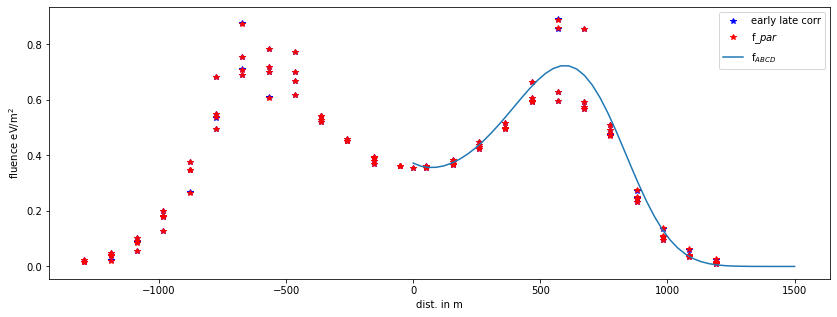

In [5]:
import matplotlib.pyplot as plt

rec = EnergyRec(simulation)

plt.figure(figsize=[14,5])
r_proj = np.array([ant.r_proj for ant in rec.antenna])
distance = np.linalg.norm((r_proj - rec.shower.r_Core_proj)[:,0:2],axis=1)
distance[(r_proj-rec.shower.r_Core_proj).T[1]<0] = - distance[(r_proj-rec.shower.r_Core_proj).T[1]<0]

fluence_arr = np.array([ant.fluence for ant in rec.antenna])
fluence_evB = np.array([ant.fluence_evB/(ant.wEarlyLate**2) for ant in rec.antenna])
fluence_par = rec.Eval_par_fluences(bestfit)

sel = np.where(fluence_arr>0.01)
plt.plot(distance[sel],fluence_evB[sel],"b*", label = "early late corr")

plt.plot(distance[sel],fluence_par[sel],"r*", label = r'f_${par}$')

ldf_par = SymFit.SymLDF_fit(np.abs(distance[sel]),fluence_par[sel])
f_par = SymFit.SymLDF(ldf_par,np.linspace(0,1500))
plt.plot(np.linspace(0,1500),f_par,"-",label=r"f$_{ABCD}$")

plt.xlabel("dist. in m")
plt.ylabel("fluence eV/m$^2$")

plt.legend()

# Training stage of the $S_{radio}$

The $f_{par}$ is fitted using 
$$f_{ABCD}(r) = A.\exp\left[-B.r -C.r^2 -D.r^3 \right] $$

The following block evaluates several quantities of interest for each simulation: the parameters of the ldf fit , the geomagnetic angle, the density at the $X_{max}$ and the energy. 

In [6]:
ldf_par_arr = np.empty(shape=(0, 4))
alpha_arr = np.array([])
rho_Xmax_arr = np.array([])
E_arr = np.array([])

for i in range(100001,100008):
    simulation = "../files/sim" + str(i) + ".hdf5"
    rec = EnergyRec(simulation)
 
    r_proj = np.array([ant.r_proj for ant in rec.antenna])
    distance = np.linalg.norm((r_proj - rec.shower.r_Core_proj)[:,0:2],axis=1)
    
    fluence_par = rec.Eval_par_fluences(bestfit)
    sel = np.where(fluence_par>0)
    
    ldf_par = SymFit.SymLDF_fit(distance[sel],fluence_par[sel])
    d_Xmax = rec.shower.d_Xmax
    rho_Xmax = SymFit.rho(d_Xmax,-rec.shower.ev)

    ldf_par_arr = np.vstack((ldf_par_arr,[ldf_par]))
    alpha_arr = np.append(alpha_arr,[np.arccos(np.dot(rec.shower.ev,rec.shower.eB))])
    rho_Xmax_arr = np.append(rho_Xmax_arr,[rho_Xmax])
    E_arr = np.append(E_arr,[rec.GRANDshower.energy.to("EeV").value])

### The energy estimator

The radiation energy (integral of the symmetric LDF) hsa to be corrected according
$$S_{rad} = \frac{E_{rad}}{\sin^2(\alpha)}.\frac{1}{1-par_0+par_0.\exp\left[par_1.(\rho_{max}-0.648\, {\rm kg/m^3}) \right]}$$

The $S_{radio}$ is related to the energy via
$$S_{rad} = S_{19}.\left( \frac{E}{10 {\rm EeV}}\right)^\gamma$$

The parameters of the above equations are obtained through a joint fit to all simulations.

In [7]:
joint_bestfit = SymFit.joint_S_fit(ldf_par_arr,alpha_arr,rho_Xmax_arr,E_arr)
print(joint_bestfit)

[ 0.6095657   3.86352134 20.60760524  1.98330928]


# $S_{radio}\times$  energy relation

When simulations for different energies are available this block will plot the relation between $S_{radio}$ and the energy.

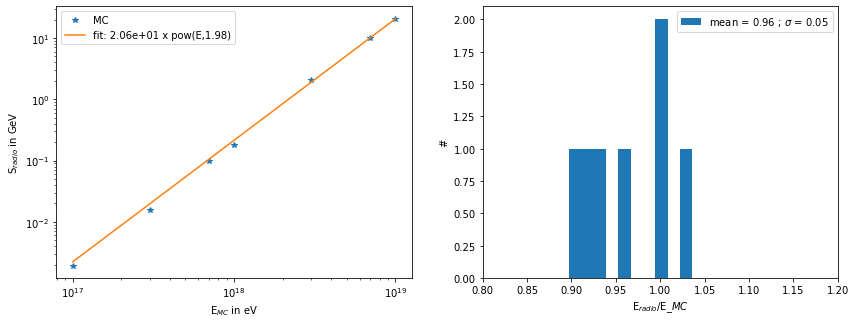

In [8]:
import matplotlib.pyplot as plt

S_geo = np.zeros(len(ldf_par_arr))
S_mod = np.zeros(len(ldf_par_arr))

for i in range(len(ldf_par_arr)):
    S_geo[i] = SymFit.Sradio_geo(joint_bestfit[0:2],ldf_par_arr[i],alpha_arr[i],rho_Xmax_arr[i])
    S_mod[i] = SymFit.Sradio_mod(joint_bestfit[2:4],E_arr[i])

plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(E_arr*1.e18,S_geo,"*",label="MC")

fit_label = "fit: "+ "{:.2e}".format(joint_bestfit[2]) + " x pow(E,"+ "{:.2f}".format(joint_bestfit[3]) +")"
fit_x = [np.min(E_arr*1.e18),np.max(E_arr*1.e18)]
fit_y = [SymFit.Sradio_mod(joint_bestfit[2:4],np.min(E_arr)), SymFit.Sradio_mod(joint_bestfit[2:4],np.max(E_arr))]
plt.plot(fit_x,fit_y,label = fit_label)
plt.legend()
plt.xlabel(r"E$_{MC}$ in eV")
plt.ylabel(r"S$_{radio}$ in GeV")
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')

plt.subplot(122)

erec = pow((S_geo/joint_bestfit[2]),1./joint_bestfit[3])*10./E_arr
e_label = r"E$_{radio}$/E_${MC}$"
stat = "mean = " +"{:.2f}".format(np.mean(erec)) + r" ; $\sigma$ = " + "{:.2f}".format(np.std(erec))
plt.hist(erec,label=stat)
plt.xlabel(e_label)
plt.xlim(0.8,1.2)
plt.ylabel("#")
plt.legend()